### Import packages
---

In [1]:
import time
import os
import copy

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

### Setup a device

In [2]:
# Device configuration

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('device:', device)

device: cuda


### Hyperparameters
---


In [3]:
batch_size = 10
learning_rate = 0.001
num_epochs = 10

### Load dataset
---

In [4]:
#Google Drive mount

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [6]:
# 압축풀기

!unzip '/content/gdrive/My Drive/kcar_lowsize(3).zip' -d "/content/dataset(2)"

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: /content/dataset(2)/i30/현대_i30_2008_17시대_H315_V30.JPG  
  inflating: /content/dataset(2)/i30/현대_i30_2008_17시대_H315_V45.JPG  
  inflating: /content/dataset(2)/i30/현대_i30_2008_17시대_H315_V60.JPG  
  inflating: /content/dataset(2)/i30/현대_i30_2008_17시대_H330_V0.JPG  
  inflating: /content/dataset(2)/i30/현대_i30_2008_17시대_H330_V15.JPG  
  inflating: /content/dataset(2)/i30/현대_i30_2008_17시대_H330_V30.JPG  
  inflating: /content/dataset(2)/i30/현대_i30_2008_17시대_H330_V45.JPG  
  inflating: /content/dataset(2)/i30/현대_i30_2008_17시대_H330_V60.JPG  
  inflating: /content/dataset(2)/i30/현대_i30_2008_17시대_H345_V0.JPG  
  inflating: /content/dataset(2)/i30/현대_i30_2008_17시대_H345_V15.JPG  
  inflating: /content/dataset(2)/i30/현대_i30_2008_17시대_H345_V30.JPG  
  inflating: /content/dataset(2)/i30/현대_i30_2008_17시대_H345_V45.JPG  
  inflating: /content/dataset(2)/i30/현대_i30_2008_17시대_H345_V60.JPG  
  inflating: /content/dataset(2)/i30/현대_i30_2008_17시대_H45_V0.JPG  
  

In [7]:
# Data augmentation and normalization for training
# Just normalization for validation

train_transforms = transforms.Compose([
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0) ),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

test_transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

dataset = datasets.ImageFolder( 'dataset(2)', train_transforms)

train_dataset, test_dataset = train_test_split(dataset,stratify=dataset.targets, test_size=0.2, random_state=100)

train_loader = DataLoader( train_dataset, batch_size=batch_size, shuffle=True )
test_loader = DataLoader( test_dataset, batch_size=batch_size, shuffle=True )

classes = dataset.classes
print(classes)


['i30', '그랜저HG240', '싼타페', '투싼']


In [8]:
print(len(test_dataset))
print(len(train_dataset))

1090
4359


### Preview the data 
---

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 53804 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49916 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 53804 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 49916 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 53440 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54168 missing from current font.
  font.set_text

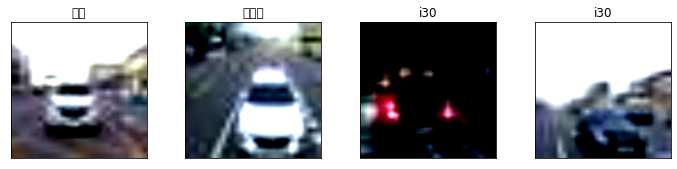

In [9]:
import matplotlib.pyplot as plt
import numpy as np

def convert_to_imshow_format(image):
    # first convert back to [0,1] range from [-1,1] range
    image = image / 2 + 0.5
    image = image.numpy()
    image = image.clip(0,1)
    # convert from CHW to HWC
    # from 3x32x32 to 32x32x3
    return image.transpose(1,2,0)

dataiter = iter(train_loader)
images, labels = dataiter.next()

images = images[:4]
labels = labels[:4]

fig, axes = plt.subplots(1, len(images), figsize=(12,2.5))
for idx, image in enumerate(images):
    axes[idx].imshow(convert_to_imshow_format(image))
    axes[idx].set_title(classes[labels[idx]])
    axes[idx].set_xticks([])
    axes[idx].set_yticks([])

### Progress monitor
---

In [10]:

from IPython.display import HTML, display

# Custom IPython progress bar for training
class ProgressMonitor(object):
    
    tmpl = """
        <table style="width: 100%;">
            <tbody>
                <tr>
                    <td style="width: 30%;">
                     <b>Epoch: {epoch}/{num_epochs} Loss: {loss:0.4f}</b> &nbsp&nbsp&nbsp {value} / {length}
                    </td>
                    <td style="width: 70%;">
                        <progress value='{value}' max='{length}', style='width: 100%'>{value}</progress>
                    </td>
                </tr>
            </tbody>
        </table>        
        """

    def __init__(self, length):
        self.length = length
        self.count = 0
        self.display = display(self.html(0, 0, 0, 0), display_id=True)
        
    def html(self, count, loss, epoch, num_epochs):
        return HTML(self.tmpl.format(length=self.length, value=count, loss=loss, epoch=epoch, num_epochs=num_epochs))
        
    def update(self, epoch, num_epochs, count, loss):
        self.count += count
        self.display.update(self.html(self.count, loss, epoch, num_epochs))

### Finetuning the convnet
---


In [12]:
class ConvEnsemble(nn.Module):
    def __init__(self):
        super().__init__()

        self.model_a = models.resnet50(pretrained=True)
        self.model_b = models.googlenet(pretrained=True)
        self.model_c = models.densenet121(pretrained=True)
        self.fc = nn.Linear(3000, len(classes) )

    def forward(self, x):
        out_a = self.model_a(x)
        out_b = self.model_b(x)
        out_c = self.model_c(x)

        out_s = torch.cat( (out_a, out_b, out_c), dim=1 )

        out = self.fc(out_s)

        return out


In [17]:
model = models.googlenet(pretrained=True)

In [18]:

model = model.to(device)

loss_func = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD( model.parameters(), lr=0.001, momentum=0.9 )

# Decay LR by a factor of 0.1 every 7 epochs
lr_scheduler_ft = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


### Train/test
---

In [19]:
def train(epoch, num_epochs, model, optimizer, scheduler):

    # train phase
    model.train()
    
    # create a progress bar
    batch_loss_list = []
    progress = ProgressMonitor(length=len(train_dataset))

    for batch, target in train_loader:
        # Move the training data to the GPU
        batch, target = batch.to(device), target.to(device)

        # forward propagation
        output = model( batch )

        # calculate the loss
        loss = loss_func( output, target )
        
        # clear previous gradient computation
        optimizer.zero_grad()
 
        # backpropagate to compute gradients
        loss.backward()
 
        # update model weights
        optimizer.step()

        # update progress bar
        batch_loss_list.append(loss.item())
        progress.update(epoch, num_epochs, batch.shape[0], sum(batch_loss_list)/len(batch_loss_list) )

    # update learning rate scheduler
    if scheduler:
        scheduler.step()

        
        

In [20]:
def test(model):
    # test phase
    model.eval()

    correct = 0
    
    # We don't need gradients for test, so wrap in 
    # no_grad to save memory
    with torch.no_grad():
        for batch, target in test_loader:
            # Move the training batch to the GPU
            batch, target = batch.to(device), target.to(device)

            # forward propagation
            output = model( batch )

            # get prediction
            output = torch.argmax(output, 1)

            # accumulate correct number
            correct += (output == target).sum().item()

    # Calculate test accuracy    
    acc = 100 * float(correct) / len(test_dataset) 
    print( 'Test Acc: {}/{} ({:.2f}%)'.format( correct, len(test_dataset), acc ) )  
    
    return acc

In [21]:

since = time.time()

# initialize the best weights
best_model_weights = copy.deepcopy( model.state_dict() )
best_acc = 0.0

for epoch in range(num_epochs):

    # train
    train(epoch+1, num_epochs, model, optimizer_ft, lr_scheduler_ft )
    # test
    acc = test(model)

    # update the best weights
    if acc > best_acc:
        best_acc = acc
        best_model_weights = copy.deepcopy( model.state_dict() )

# load the best weights
model.load_state_dict( best_model_weights )

# summary
time_elapsed = time.time() - since
print('Training completed in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
print('Best test accuracy: {:4f}'.format(best_acc))



Epoch: 1/10 Loss: 1.1275 4359 / 4359,4359


Test Acc: 890/1090 (81.65%)


Epoch: 2/10 Loss: 0.4208 4359 / 4359,4359


Test Acc: 980/1090 (89.91%)


Epoch: 3/10 Loss: 0.2317 4359 / 4359,4359


Test Acc: 981/1090 (90.00%)


Epoch: 4/10 Loss: 0.1580 4359 / 4359,4359


Test Acc: 1019/1090 (93.49%)


Epoch: 5/10 Loss: 0.1020 4359 / 4359,4359


Test Acc: 1030/1090 (94.50%)


Epoch: 6/10 Loss: 0.0788 4359 / 4359,4359


Test Acc: 1047/1090 (96.06%)


Epoch: 7/10 Loss: 0.0804 4359 / 4359,4359


Test Acc: 1040/1090 (95.41%)


Epoch: 8/10 Loss: 0.0502 4359 / 4359,4359


Test Acc: 1055/1090 (96.79%)


Epoch: 9/10 Loss: 0.0375 4359 / 4359,4359


Test Acc: 1061/1090 (97.34%)


Epoch: 10/10 Loss: 0.0302 4359 / 4359,4359


Test Acc: 1059/1090 (97.16%)
Training completed in 4m 3s
Best test accuracy: 97.339450
